In [ ]:
from google.colab import files
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import os
import tensorflow as tf
import zipfile
from tensorflow import keras
from tensorflow.keras import layers
import nibabel as nib
import glob
from sklearn.utils import shuffle
import sys


In [ ]:
from keras.utils import np_utils
from keras.layers import Conv3D, MaxPool3D, Flatten, Dense
from keras.layers import Dropout, Input, BatchNormalization
from sklearn.metrics import confusion_matrix, accuracy_score
from keras.losses import binary_crossentropy
from keras.optimizers import Adadelta, SGD
from matplotlib.pyplot import cm
import matplotlib.pyplot as plt
from keras.models import Model
import cv2
import os
import numpy as np
import keras
import h5py
import numpy as np
from keras import regularizers
import os
import glob
import cv2
import random
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score

from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras import optimizers
# from keras.utils import to_categorical, plot_model
from keras.layers import Dense, Input, Conv2D, Flatten, MaxPooling2D, Activation
from keras.models import Model, Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
from keras.models import load_model
from keras.utils import np_utils
from keras import backend as K
from keras.models import load_model

In [ ]:
seed = 7
np.random.seed(seed)

In [ ]:
x_train = np.load("/content/drive/MyDrive/thesis2/x_train_minmax_normalized.npy")
y_train = np.load("/content/drive/MyDrive/thesis2/y_training.npy")

In [ ]:
x_train.shape,y_train.shape

((6000, 64, 64, 33), (6000,))

In [ ]:
# x_mean = np.mean(x_train)
# x_std = np.std(x_train)
# x_mean,x_std
# # (1553.0166624964165, 3575.5203140146095)

(0.22945192119659386, 0.10349581814834698)

In [ ]:
m , mi = 28822.50390625, -6477.419921875

In [ ]:
np.max(x_train),np.min(x_train)

(1.0, 0.0)

In [ ]:
# x_train = (x_train - mi) / (m - mi)

In [ ]:
# m , mi = 2521.0,0.0

In [ ]:
# x_train = (x_train- x_mean)/x_std

In [ ]:
x_test = np.load("/content/drive/MyDrive/thesis2/x_test.npy")
y_test = np.load("/content/drive/MyDrive/thesis2/y_test.npy")

In [ ]:
x_test.shape,y_test.shape

((900, 64, 64, 33), (900,))

In [ ]:
x_test = (x_test - mi) / (m - mi)

In [ ]:
x_val = np.load("/content/drive/MyDrive/thesis2/x_validation2.npy")
y_val = np.load("/content/drive/MyDrive/thesis2/y_validation2.npy")

In [ ]:
x_val.shape,y_val.shape

((900, 64, 64, 33), (900,))

In [ ]:
x_val = (x_val - mi) / (m - mi)

In [ ]:
import os
import zipfile
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
def get_model(width=128, height=128, depth=64):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=64, kernel_size=3,padding='same', activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2,padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, padding='same',activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2,padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3,padding='same', activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2,padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3,padding='same', activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2,padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = get_model(width=64, height=64, depth=33)
model.summary()


Model: "3dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 33, 1)]   0         
_________________________________________________________________
conv3d (Conv3D)              (None, 64, 64, 33, 64)    1792      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 32, 32, 17, 64)    0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 17, 64)    256       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 32, 32, 17, 64)    110656    
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 16, 16, 9, 64)     0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 9, 64)     256   

In [ ]:
# from tensorflow.python.framework.ops import disable_eager_execution
# enable_eager_execution()

NameError: ignored

In [ ]:
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)

# Define callbacks.
checkpoint_accuracy = keras.callbacks.ModelCheckpoint(
    "best_accuracy.h5", save_best_only=True,monitor = 'val_acc',mode = 'max'
)
checkpoint_validation = keras.callbacks.ModelCheckpoint(
    "best_loss.h5", save_best_only=True,monitor = 'val_loss',mode = 'min'
)
# early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

# Train the model, doing validation at the end of each epoch
epochs = 50
history = model.fit(
    x = x_train,y = y_train,
    validation_data=(x_val,y_val),
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_accuracy,checkpoint_validation, ],
)

Epoch 1/50
188/188 - 40s - loss: 0.0986 - acc: 0.9743 - val_loss: 2.3818 - val_acc: 0.5000
Epoch 2/50
188/188 - 21s - loss: 8.3917e-04 - acc: 1.0000 - val_loss: 3.1970 - val_acc: 0.5000
Epoch 3/50
188/188 - 21s - loss: 2.9712e-04 - acc: 1.0000 - val_loss: 3.0622 - val_acc: 0.5000
Epoch 4/50
188/188 - 21s - loss: 1.7014e-04 - acc: 1.0000 - val_loss: 1.2305 - val_acc: 0.6344
Epoch 5/50
188/188 - 21s - loss: 9.4368e-05 - acc: 1.0000 - val_loss: 1.3009 - val_acc: 0.6667
Epoch 6/50
188/188 - 21s - loss: 7.7400e-05 - acc: 1.0000 - val_loss: 1.4157 - val_acc: 0.6667
Epoch 7/50
188/188 - 21s - loss: 3.8623e-05 - acc: 1.0000 - val_loss: 1.4698 - val_acc: 0.6667
Epoch 8/50
188/188 - 21s - loss: 3.3066e-05 - acc: 1.0000 - val_loss: 1.5032 - val_acc: 0.6667
Epoch 9/50
188/188 - 21s - loss: 4.1294e-05 - acc: 1.0000 - val_loss: 1.4694 - val_acc: 0.6667
Epoch 10/50
188/188 - 21s - loss: 2.7675e-05 - acc: 1.0000 - val_loss: 1.6478 - val_acc: 0.6667
Epoch 11/50
188/188 - 21s - loss: 1.8116e-05 - acc: 1

In [ ]:
model.save('last_model.h5')

In [ ]:
import os
import zipfile
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers


Separate graphs

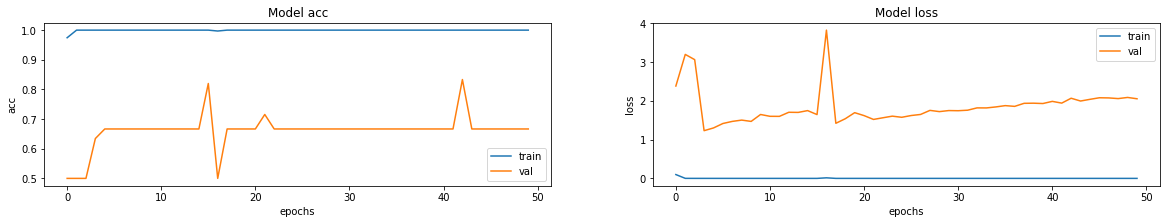

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [ ]:
y_train[:10]

array([1, 0, 1, 0, 0, 0, 1, 1, 0, 0])

Shuffling the test set

In [ ]:
x_test2, y_test2= shuffle(x_test,y_test,random_state = 4)

Evaluating last model on test set

In [ ]:
model.evaluate(x = x_test2,y = y_test2)

29/29 [==============================] - 1s 42ms/step - loss: 3.4679 - acc: 0.6711


[3.4678759574890137, 0.6711111068725586]

Evaluating last model on validation set

In [ ]:
model.evaluate(x = x_val,y = y_val)

29/29 [==============================] - 1s 42ms/step - loss: 2.0532 - acc: 0.6667


[2.0532302856445312, 0.6666666865348816]

Loading the best accuracy model

In [ ]:
model1 = load_model('best_accuracy.h5')

In [ ]:
# 3 images each without image scz 27
x_test5 = np.load("/content/drive/MyDrive/thesis2/x_test5.npy")
y_test5 = np.load("/content/drive/MyDrive/thesis2/y_test5.npy")

In [ ]:
# all images except scz 27

x_test6 = np.load("/content/drive/MyDrive/thesis2/x_test6.npy")
y_test6 = np.load("/content/drive/MyDrive/thesis2/y_test6.npy")

Evaluating best accuracy model on test set


In [ ]:
model.evaluate(x = x_test,y = y_test)

47/47 [==============================] - 2s 47ms/step - loss: 219297.6875 - acc: 0.3000


[219297.6875, 0.30000001192092896]

Evaluating best accuracy model on validation  set

In [ ]:
model1.evaluate(x = x_val,y = y_val)

29/29 [==============================] - 1s 42ms/step - loss: 2.0670 - acc: 0.8333


[2.066983938217163, 0.8333333134651184]

Loading the best loss model

In [ ]:
model2 = load_model('best_loss.h5')

Evaluating best loss model on test set

In [ ]:
model2.evaluate(x = x_test2,y = y_test2)

29/29 [==============================] - 2s 42ms/step - loss: 2.2989 - acc: 0.5000


[2.298898696899414, 0.5]

Evaluating best loss model on validation set

In [ ]:
model2.evaluate(x = x_val,y = y_val)

29/29 [==============================] - 1s 42ms/step - loss: 1.2305 - acc: 0.6344


[1.230513095855713, 0.6344444155693054]

Calculating different metrics

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix


In [ ]:
y_test[:4]

array([1, 0, 1, 0])

In [ ]:
y_prob= model.predict(x_test2, verbose=0)
y_prob = y_prob[:, 0]

y_classes = (y_prob > 0.5).astype(np.int)


# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_classes)
print('F1 score: %f' % f1)
 
# kappa
kappa = cohen_kappa_score(y_test, y_classes)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, y_prob)
print('ROC AUC: %f' % auc)
# confusion matrix
print("Confusion matrix:")
matrix = confusion_matrix(y_test, y_classes,labels=[1,0])
print(matrix)

Accuracy: 0.500000
Precision: 0.500000
Recall: 0.664444
F1 score: 0.570611
Cohens kappa: 0.000000
ROC AUC: 0.508899
Confusion matrix:
[[299 151]
 [299 151]]


In [ ]:
y_classes[:10]

array([0, 1, 1, 0, 1, 1, 1, 0, 1, 1])

In [ ]:
sensitivity = matrix[0,0]/(matrix[0,0]+matrix[0,1])
print('Sensitivity : ', sensitivity )

specificity = matrix[1,1]/(matrix[1,0]+matrix[1,1])
print('Specificity : ', specificity)

Sensitivity :  0.8571428571428571
Specificity :  0.6666666666666666


In [ ]:
y_test[:10]

array([1, 0, 1, 0, 1, 1, 1, 0, 0, 1])

In [ ]:
y_val[:10]

array([1, 0, 1, 0, 1, 1, 1, 0, 0, 1])

In [ ]:
y_train[:10]

array([1, 0, 1, 0, 0, 0, 1, 1, 0, 0])

In [ ]:
cd /

/


In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Orm2tbk5gljhnRrZ56onxRdmIUWvYt-X' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1Orm2tbk5gljhnRrZ56onxRdmIUWvYt-X" -O finaltest.zip && rm -rf /tmp/cookies.txt


--2021-05-17 23:55:38--  https://docs.google.com/uc?export=download&confirm=izR9&id=1Orm2tbk5gljhnRrZ56onxRdmIUWvYt-X
Resolving docs.google.com (docs.google.com)... 173.194.79.139, 173.194.79.113, 173.194.79.138, ...
Connecting to docs.google.com (docs.google.com)|173.194.79.139|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0g-5s-docs.googleusercontent.com/docs/securesc/pb60cjjjvvv0db43il8v6oc0sfpt158u/4ckpc0tinl79lva7pnt8h6ma8e6vot83/1621295700000/10681116013986523016/02639302157970986819Z/1Orm2tbk5gljhnRrZ56onxRdmIUWvYt-X?e=download [following]
--2021-05-17 23:55:38--  https://doc-0g-5s-docs.googleusercontent.com/docs/securesc/pb60cjjjvvv0db43il8v6oc0sfpt158u/4ckpc0tinl79lva7pnt8h6ma8e6vot83/1621295700000/10681116013986523016/02639302157970986819Z/1Orm2tbk5gljhnRrZ56onxRdmIUWvYt-X?e=download
Resolving doc-0g-5s-docs.googleusercontent.com (doc-0g-5s-docs.googleusercontent.com)... 172.217.218.132, 2a00:1450:4013:c01::84
Connectin

In [ ]:
# from google.colab import files
# files.download('example.txt') 
!unzip /finaltest.zip -d /
print('done')

Archive:  /finaltest.zip
   creating: /scz_test/
  inflating: /scz_test/18.nii.gz     
  inflating: /scz_test/19.nii.gz     
  inflating: /scz_test/20.nii.gz     
  inflating: /scz_test/21.nii.gz     
  inflating: /scz_test/22.nii.gz     
  inflating: /scz_test/23.nii.gz     
  inflating: /scz_test/24.nii.gz     
  inflating: /scz_test/25.nii.gz     
  inflating: /scz_test/26.nii.gz     
  inflating: /scz_test/27.nii.gz     
  inflating: /scz_test/28.nii.gz     
  inflating: /scz_test/29.nii.gz     
  inflating: /scz_test/30.nii.gz     
  inflating: /scz_test/31.nii.gz     
   creating: /normal_test/
  inflating: /normal_test/18.nii.gz  
  inflating: /normal_test/19.nii.gz  
  inflating: /normal_test/20.nii.gz  
  inflating: /normal_test/21.nii.gz  
  inflating: /normal_test/22.nii.gz  
  inflating: /normal_test/23.nii.gz  
  inflating: /normal_test/24.nii.gz  
  inflating: /normal_test/25.nii.gz  
  inflating: /normal_test/26.nii.gz  
done


In [ ]:
normaltest = []
scztest = []

In [ ]:
flag = 0
count = 0
for file in glob.glob('/normal_test/*'):
  count= count+1
  print(file)
  img4d = nib.load(file)
  img3d_list = nib.funcs.four_to_three(img4d)
  for i in img3d_list:
    data = i.get_fdata()
    normaltest.append(data)
    
  #   if (len(scz)==2500):
  #     flag = 1
  #     if(flag == 1):
  #       break
  # if(flag == 1):
  #   break
print("done")
print(count)

/normal_test/19.nii.gz
/normal_test/21.nii.gz
/normal_test/25.nii.gz
/normal_test/23.nii.gz
/normal_test/20.nii.gz
/normal_test/22.nii.gz
/normal_test/24.nii.gz
/normal_test/18.nii.gz
/normal_test/26.nii.gz
done
9


In [ ]:
flag = 0
count = 0
for file in glob.glob('/scz_test/*'):
  count= count+1
  print(file)
  img4d = nib.load(file)
  img3d_list = nib.funcs.four_to_three(img4d)
  for i in img3d_list:
    data = i.get_fdata()
    scztest.append(data)
    
  #   if (len(scz)==2500):
  #     flag = 1
  #     if(flag == 1):
  #       break
  # if(flag == 1):
  #   break
print("done")
print(count)

/scz_test/29.nii.gz
/scz_test/19.nii.gz
/scz_test/21.nii.gz
/scz_test/25.nii.gz
/scz_test/28.nii.gz
/scz_test/23.nii.gz
/scz_test/30.nii.gz
/scz_test/31.nii.gz
/scz_test/20.nii.gz
/scz_test/22.nii.gz
/scz_test/24.nii.gz
/scz_test/18.nii.gz
/scz_test/27.nii.gz
/scz_test/26.nii.gz
done
14


In [ ]:
normaltest_labels = np.array([0 for _ in range(len(normaltest))])
scztest_labels = np.array([1 for _ in range(len(scztest))])


y = np.concatenate((normaltest_labels[:], scztest_labels[:]), axis=0)

In [ ]:
normaltest_array = np.asarray(normaltest)
normaltest_array =(normaltest_array- x_mean)/x_std
scztest_array = np.asarray(scztest)
scztest_array =(scztest_array- x_mean)/x_std


x_test = np.concatenate((normaltest_array[:], scztest_array[:]), axis=0)

In [ ]:
y.shape

(3450,)

In [ ]:
score = model.evaluate(x = x_test,y = y)

108/108 [==============================] - 5s 45ms/step - loss: 98312.4609 - acc: 0.8157


In [ ]:
model.save('model1.h5')

In [ ]:
model = load_model('model1.h5')

In [ ]:
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

acc: 100.00%


In [ ]:
def plot_loss_accu(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'g')
    plt.plot(epochs, val_loss, 'y')
    plt.title('Training loss')
    plt.legend(['train', 'val'], loc='upper right')
    plt.grid()
    plt.show()
    loss = history.history['acc']
    val_loss = history.history['val_acc']
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'r')
    plt.plot(epochs, val_loss, 'b')
    plt.title('Training accuracy')
    plt.legend(['train', 'val'], loc='lower right')
    plt.grid()
    plt.show()

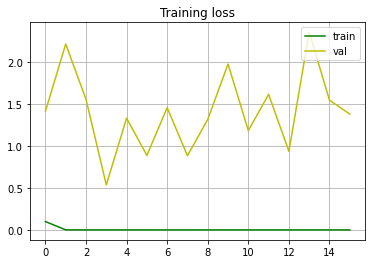

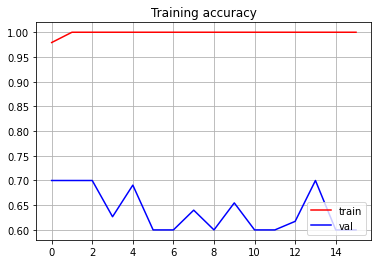

In [ ]:
plot_loss_accu(history) 